In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten, Reshape

### **Load the Saved Preprocessed Data with Aspects**

In [2]:
data = pd.read_csv("data.csv")
data.head()

,processed_review,text_aspect_sentiment
0,great phone budget pubg performance rough came...,['great phone budget pubg performance rough ca...
1,well smartphone mi range bear r confused samsu...,['well smartphone mi range bear r confused sam...
2,bad smooth phone back camera quality bad rear ...,['bad smooth phone back camera quality bad rea...
3,thise nice mobile I like much delivery also fa...,[]
4,I meagerly fall short thumb section r superb d...,['I meagerly fall short thumb section r superb...


#### **Removal of Null Samples**

In this step, the code is performing the following operations:

1. **Creating a Boolean Mask:**
   - A boolean mask is created using the condition `data['text_aspect_sentiment'] == '[]'`.
   - This mask will be `True` for rows where the value in the 'text_aspect_sentiment' column is equal to the string '[]' (an empty set of square brackets).

2. **Inverting the Mask:**
   - The `~` (tilde) operator is used to invert the boolean mask.
   - This inversion results in a mask where `True` corresponds to rows that do not have '[]' in the 'text_aspect_sentiment' column, and `False` corresponds to rows with '[]'.

3. **Filtering the Data:**
   - The inverted mask is applied to the original DataFrame (`data`) using boolean indexing.
   - The resulting `filtered_data` contains only the rows where the 'text_aspect_sentiment' column does not have the value '[]'.


In [3]:
# Create a boolean mask to identify rows where 'text_aspect_sentiment' is '[]'
mask = data['text_aspect_sentiment'] == '[]'

# Invert the mask to keep rows that don't have '[]'
filtered_data = data[~mask]

In [4]:
filtered_data.head()

,processed_review,text_aspect_sentiment
0,great phone budget pubg performance rough came...,['great phone budget pubg performance rough ca...
1,well smartphone mi range bear r confused samsu...,['well smartphone mi range bear r confused sam...
2,bad smooth phone back camera quality bad rear ...,['bad smooth phone back camera quality bad rea...
4,I meagerly fall short thumb section r superb d...,['I meagerly fall short thumb section r superb...
5,great product price segmentit deliver well per...,['great product price segmentit deliver well p...


In [5]:
print('Original data: ', data.shape)
print('Filtered data:', filtered_data.shape)

Original data:  (9606, 2)
Filtered data: (9007, 2)


The augmented data had 9606 rows and 2 columns. After applying the filtering operation to remove rows where the 'text_aspect_sentiment' column is equal to '[]', the filtered data now consists of 9012 rows and 2 columns. The reduction in the number of rows from 9606 to 9012 indicates that some rows were removed during the filtering process, keeping only those rows where 'text_aspect_sentiment' does not have the value '[]'.

### **Decoding - Data Preparation**

The code uses the `eval` function to convert the string representation of a list in the `text_aspect_sentiment` column to an actual list. It then iterates over each element in this list, splitting it into parts using specific delimiters ('aaaa' and 'xxxx').

The separated parts include the sentence, aspect, and sentiment information. These parts are then appended to separate lists (`sentences`, `aspects`, and `sentiments`). Finally, a new DataFrame (`text_aspect_sentiment_data`) is created using these lists, with columns for the separated data: 'sentence', 'aspect', and 'sentiment'. The entire process is timed using `%%time` to measure the execution time.

In [6]:
%%time

# Create empty lists to store the separated data
sentences = []
aspects = []
sentiments = []

# Loop over each row in the DataFrame
for index, row in filtered_data.iterrows():
    # Convert the string representation of the list to an actual list
    text_aspect_sentiment_list = eval(row['text_aspect_sentiment'])

    # Loop over each element in the list
    for text in text_aspect_sentiment_list:
        # Split the text using the specified delimiters
        parts = text.split('aaaa')
        sentence = parts[0]
        aspect = parts[1].split('xxxx')[0]
        sentiment = int(parts[1].split('xxxx')[1])

        # Append the separated data to the respective lists
        sentences.append(sentence)
        aspects.append(aspect)
        sentiments.append(sentiment)

# Create a new DataFrame with the separated data
text_aspect_sentiment_data = pd.DataFrame({
    'sentence': sentences,
    'aspect': aspects,
    'sentiment': sentiments
})


CPU times: total: 312 ms
Wall time: 316 ms


In [7]:
text_aspect_sentiment_data.head()

,sentence,aspect,sentiment
0,great phone budget pubg performance rough came...,phone,0
1,great phone budget pubg performance rough came...,camera,0
2,great phone budget pubg performance rough came...,performance,0
3,well smartphone mi range bear r confused samsu...,phone,0
4,well smartphone mi range bear r confused samsu...,price,0


#### Sentiment Distribution

In [8]:
text_aspect_sentiment_data.sentiment.value_counts()

sentiment
1    17770
0     6652
Name: count, dtype: int64

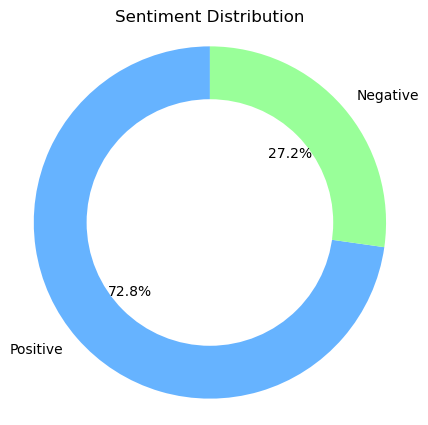

In [9]:
# Count the occurrences of each sentiment
sentiment_counts = text_aspect_sentiment_data['sentiment'].value_counts()

# Set up figure and axis
plt.figure(figsize=(5,5))

# Create a donut chart
plt.pie(sentiment_counts, labels=['Positive', 'Negative'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])

# Draw a white circle at the center to create a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that the donut chart is circular
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()


- **Positive Sentiment (Label 1):**
  - Appears in 17774 instances.

- **Negative Sentiment (Label 0):**
  - Appears in 6644 instances.

These counts represent the distribution of sentiment labels in the dataset. The higher count for Label 1 suggests that there are more instances of positive sentiment compared to negative sentiment.

#### Aspect Distribution

In [10]:
text_aspect_sentiment_data.aspect.value_counts()

aspect
phone           5301
camera          4777
battery         3592
price           2488
performance     2380
product         1980
display         1869
quality         1755
acamera           68
aphone            62
aperformance      33
aprice            32
abattery          31
aquality          26
adisplay          18
aproduct          10
Name: count, dtype: int64

In [11]:
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\baphone\b', 'phone', regex=True)
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\bacamera\b', 'phone', regex=True)
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\baperformance\b', 'phone', regex=True)
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\baprice\b', 'phone', regex=True)
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\babattery\b', 'phone', regex=True)
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\baquality\b', 'phone', regex=True)
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\badisplay\b', 'phone', regex=True)
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\baproduct\b', 'phone', regex=True)

In [12]:
text_aspect_sentiment_data.aspect.value_counts()

aspect
phone          5581
camera         4777
battery        3592
price          2488
performance    2380
product        1980
display        1869
quality        1755
Name: count, dtype: int64

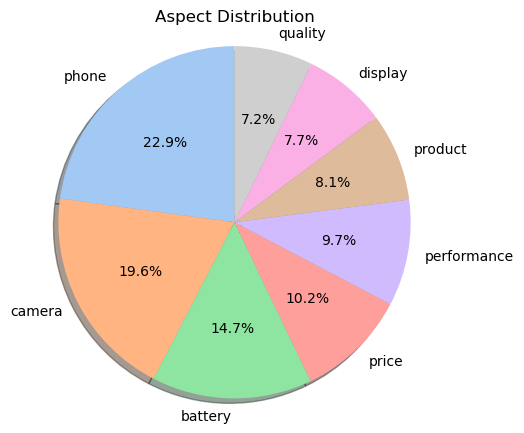

In [13]:
# Count the occurrences of each aspect
aspect_counts = text_aspect_sentiment_data['aspect'].value_counts()

# Set up figure and axis
plt.figure(figsize=(5,5))

# Create a pie chart with shadow and annotations
plt.pie(aspect_counts, labels=aspect_counts.index, autopct='%1.1f%%', startangle=90, shadow=True, colors=sns.color_palette('pastel'))

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')
plt.title('Aspect Distribution')
plt.show()


- **Phone Aspect:**
  - Represents approximately 15.4% of the total aspects.

- **Camera Aspect:**
  - Represents approximately 13.2% of the total aspects.

- **Battery Aspect:**
  - Represents approximately 9.9% of the total aspects.

- **Price Aspect:**
  - Represents approximately 6.8% of the total aspects.

- **Performance Aspect:**
  - Represents approximately 6.5% of the total aspects.

- **Product Aspect:**
  - Represents approximately 5.4% of the total aspects.

- **Display Aspect:**
  - Represents approximately 5.1% of the total aspects.

- **Quality Aspect:**
  - Represents approximately 4.8% of the total aspects.

These percentages provide a relative measure of the distribution of each aspect in the dataset, indicating the proportional importance of each aspect in user reviews.

### **Data Splitting**

In [14]:
sentences = text_aspect_sentiment_data['sentence'].to_list()
aspects = text_aspect_sentiment_data['aspect'].to_list()
sentiment_labels = text_aspect_sentiment_data['sentiment'].to_list()  # 1: Positive, 0: Negative


# Create a combined list of sentences and aspects
all_text = sentences + aspects

# Create a word index using all_text
word_index = {word: idx + 1 for idx, word in enumerate(set(' '.join(all_text).split()))}

# Convert sentences and aspects to sequences using word_index
seq_sentences = [[word_index[word] for word in sentence.split()] for sentence in sentences]
seq_aspects = [[word_index[word] for word in aspect.split()] for aspect in aspects]

# Pad sequences to ensure equal length
padded_sentences = pad_sequences(seq_sentences)
padded_aspects = pad_sequences(seq_aspects)

In [15]:
from sklearn.model_selection import train_test_split

X = np.hstack((padded_sentences, padded_aspects))

X_train, X_test, y_train, y_test = train_test_split(X, sentiment_labels, test_size=0.2, random_state=42, stratify=sentiment_labels)

In [16]:
padded_sentences_X_train = X_train[:, :padded_sentences.shape[1]]
padded_aspects_X_train = X_train[:, padded_sentences.shape[1]:]

padded_sentences_X_test = X_test[:, :padded_sentences.shape[1]]
padded_aspects_X_test = X_test[:, padded_sentences.shape[1]:]

print("Shapes Information\n")
print("padded_sentences_X_train: ", padded_sentences_X_train.shape)
print("padded_aspects_X_train: ", padded_aspects_X_train.shape)
print("padded_sentences_X_test: ", padded_sentences_X_test.shape)
print("padded_aspects_X_test: ", padded_aspects_X_test.shape)
print("y_train: ", np.array(y_train).shape)
print("y_test: ", np.array(y_test).shape)

Shapes Information

padded_sentences_X_train:  (19537, 84)
padded_aspects_X_train:  (19537, 1)
padded_sentences_X_test:  (4885, 84)
padded_aspects_X_test:  (4885, 1)
y_train:  (19537,)
y_test:  (4885,)


# Model Training and Evaluation Functions
#### This cell defines the core functions for building, training, and evaluating models based on different configurations. It includes:

#### train_model_with_config(config): Builds and trains a model using a configuration dictionary, then returns the model, its training history, and evaluation metrics.
#### train_multiple_models(config_list): Iterates over multiple configurations and trains the models accordingly.
#### plot_model_performance(metrics_dict): Generates bar plots for each model’s performance metrics.

# A combined function that will simply fetch the model architecture and train and then plot some metrices

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, LSTM, Dense, Concatenate,
                                    Bidirectional, Dropout, Flatten, Reshape,
                                    SpatialDropout1D, GlobalMaxPooling1D, GlobalAveragePooling1D)
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_model_with_config(config):
    vocab_size = len(word_index) + 1
    model_type = config.get("model_type", "lstm").lower()
    embedding_dim = config.get("embedding_dim", 64)
    lstm_units = config.get("lstm_units", 128)
    dropout_rate = config.get("dropout_rate", 0.3)
    optimizer_lr = config.get("optimizer_lr", 1e-4)
    epochs = config.get("epochs", 30)
    batch_size = config.get("batch_size", 64)
    
    if model_type == "lstm":
        text_input = Input(shape=(padded_sentences.shape[1],))
        aspect_input = Input(shape=(padded_aspects.shape[1],))
        text_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(text_input)
        aspect_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(aspect_input)
        flat_text = Flatten()(text_embedding)
        flat_aspect = Flatten()(aspect_embedding)
        merged = Concatenate(axis=-1)([flat_text, flat_aspect])
        reshaped = Reshape((1, -1))(merged)
        lstm_out = LSTM(lstm_units)(reshaped)
        output = Dense(1, activation='sigmoid')(lstm_out)
        model = Model(inputs=[text_input, aspect_input], outputs=output)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    elif model_type == "bilstm":
        l2_reg = config.get("l2_reg", 1e-4)
        text_input = Input(shape=(padded_sentences.shape[1],))
        aspect_input = Input(shape=(padded_aspects.shape[1],))
        text_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(text_input)
        text_embedding = Dropout(dropout_rate)(text_embedding)
        aspect_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(aspect_input)
        aspect_embedding = Dropout(dropout_rate)(aspect_embedding)
        merged_embeddings = Concatenate(axis=1)([text_embedding, aspect_embedding])
        bilstm_out = Bidirectional(LSTM(lstm_units, dropout=dropout_rate, 
                                        recurrent_dropout=dropout_rate))(merged_embeddings)
        bilstm_out = Dropout(dropout_rate)(bilstm_out)
        output = Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))(bilstm_out)
        model = Model(inputs=[text_input, aspect_input], outputs=output)
        optimizer = tf.keras.optimizers.Adam(learning_rate=optimizer_lr)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    elif model_type == "enhanced_bilstm":
        l2_reg = config.get("l2_reg", 1e-4)
        dense_dropout_rate = config.get("dense_dropout_rate", 0.5)
        text_input = Input(shape=(padded_sentences.shape[1],))
        aspect_input = Input(shape=(padded_aspects.shape[1],))
        text_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(text_input)
        text_embedding = SpatialDropout1D(dropout_rate)(text_embedding)
        aspect_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(aspect_input)
        aspect_embedding = SpatialDropout1D(dropout_rate)(aspect_embedding)
        text_bilstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(text_embedding)
        aspect_bilstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(aspect_embedding)
        text_maxpool = GlobalMaxPooling1D()(text_bilstm)
        text_avgpool = GlobalAveragePooling1D()(text_bilstm)
        aspect_maxpool = GlobalMaxPooling1D()(aspect_bilstm)
        aspect_avgpool = GlobalAveragePooling1D()(aspect_bilstm)
        merged = Concatenate()([text_maxpool, text_avgpool, aspect_maxpool, aspect_avgpool])
        dense_256 = Dense(256, activation='relu')(merged)
        drop_layer = Dropout(dense_dropout_rate)(dense_256)
        dense_128 = Dense(128, activation='relu')(drop_layer)
        output = Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))(dense_128)
        model = Model(inputs=[text_input, aspect_input], outputs=output)
        optimizer = tf.keras.optimizers.Adam(learning_rate=optimizer_lr)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    else:
        raise ValueError("Invalid model_type. Choose from 'lstm', 'bilstm', or 'enhanced_bilstm'")
    
    history = model.fit([padded_sentences_X_train, padded_aspects_X_train],
                        np.array(y_train),
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        verbose=1)
    
    y_pred_prob = model.predict([padded_sentences_X_test, padded_aspects_X_test])
    y_pred = np.round(y_pred_prob)
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0)
    }
    
    return model, history, metrics

def train_multiple_models(config_list):
    all_metrics = {}
    histories = {}
    models = {}
    
    for config in config_list:
        model_name = config.get("name", config.get("model_type", "model"))
        print("--"*50)
        print(f"The model being trained is {config['name']} and model type is {config['model_type']}")
        print(f"The set of hyper-parameters being used are - \n{config}\n")
        print("--"*50)

        model, history, metrics = train_model_with_config(config)
        models[model_name] = model
        histories[model_name] = history
        all_metrics[model_name] = metrics
        print(f"Trained {model_name}: {metrics}")
    
    return models, histories, all_metrics

def plot_model_performance(metrics_dict):
    for model_name, metrics in metrics_dict.items():
        plt.figure(figsize=(6, 4))
        metric_names = list(metrics.keys())
        metric_values = [metrics[m] for m in metric_names]
        colors = ['skyblue', 'lightgreen', 'salmon', 'plum']
        plt.bar(metric_names, metric_values, color=colors)
        plt.title(f'Performance Metrics for {model_name}')
        plt.ylim(0, 1)
        plt.ylabel('Score')
        for i, value in enumerate(metric_values):
            plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontweight='bold')
        plt.show()

# Plot Training Curves Function
#### This cell defines the plot_training_curves function. It plots training curves (accuracy and loss) for models with multiple configurations. The function supports:

#### Individual plots per configuration (if separate_plots=True).
#### Combined plots overlaying curves from all configurations for each model type.

In [ ]:

import matplotlib.pyplot as plt

def plot_training_curves(nested_histories, separate_plots=True):
    for model_type, config_dict in nested_histories.items():
        if separate_plots:
            for config_name, history in config_dict.items():
                fig, axes = plt.subplots(1, 2, figsize=(12, 5))
                epochs = range(1, len(history.history['accuracy']) + 1)
                
                axes[0].plot(epochs, history.history['accuracy'], label='Train Accuracy', color='green')
                axes[0].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='blue')
                axes[0].set_title(f'{model_type} - {config_name} Accuracy')
                axes[0].set_xlabel('Epochs')
                axes[0].set_ylabel('Accuracy')
                axes[0].legend()
                
                axes[1].plot(epochs, history.history['loss'], label='Train Loss', color='green')
                axes[1].plot(epochs, history.history['val_loss'], label='Validation Loss', color='blue')
                axes[1].set_title(f'{model_type} - {config_name} Loss')
                axes[1].set_xlabel('Epochs')
                axes[1].set_ylabel('Loss')
                axes[1].legend()
                
                plt.tight_layout()
                plt.show()

        

        
        plt.tight_layout()
        plt.show()

# Hyper-Parameter Set CF1 – Training and Performance Plotting
#### This cell defines a second set of hyper-parameter dictionaries (H_params_1). It then trains models with these configurations using train_multiple_models and finally plots the performance metrics using plot_model_performance.

----------------------------------------------------------------------------------------------------
The model being trained is LSTM_hparam1 and model type is lstm
The set of hyper-parameters being used are - 
{'name': 'LSTM_hparam1', 'model_type': 'lstm', 'embedding_dim': 64, 'lstm_units': 128, 'dropout_rate': 0.3, 'optimizer_lr': 0.001, 'epochs': 30, 'batch_size': 64}

----------------------------------------------------------------------------------------------------
Epoch 1/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7884 - loss: 0.4316 - val_accuracy: 0.8872 - val_loss: 0.2569
Epoch 2/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9116 - loss: 0.2146 - val_accuracy: 0.8951 - val_loss: 0.2519
Epoch 3/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9202 - loss: 0.1770 - val_accuracy: 0.8953 - val_loss: 0.2569
Epoch 4/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9296 - loss: 0.1522 - val_accuracy: 0.8892 - val_loss: 0.2625
Epoch 5/3

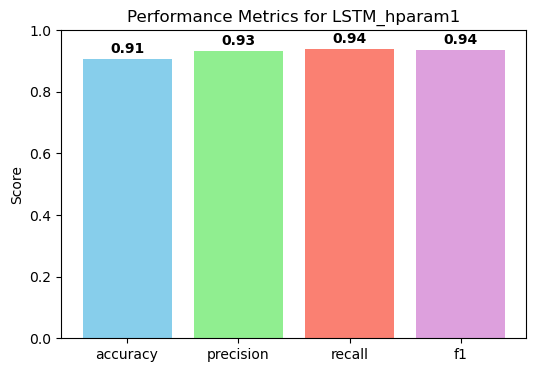

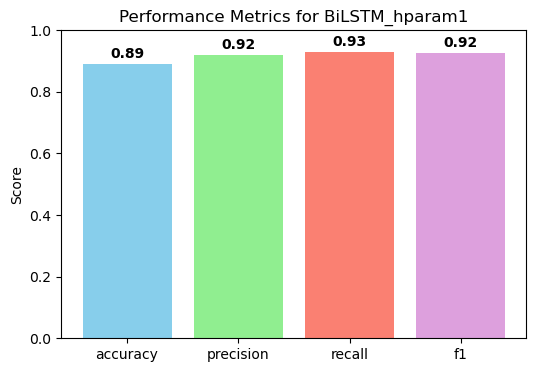

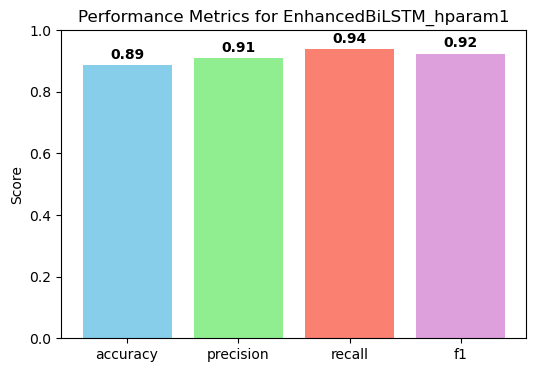

In [39]:
hyper_parameters_lstm1 = [
    {
        "name": "LSTM_hparam1",
        "model_type": "lstm",
        "embedding_dim": 64,
        "lstm_units": 128,
        "dropout_rate": 0.3,
        "optimizer_lr": 1e-3,
        "epochs": 30,
        "batch_size": 64
    },
    {
        "name": "BiLSTM_hparam1",
        "model_type": "bilstm",
        "embedding_dim": 128,
        "lstm_units": 128,
        "dropout_rate": 0.3,
        "l2_reg": 1e-4,
        "optimizer_lr": 1e-4,
        "epochs": 30,
        "batch_size": 64
    },
    {
        "name": "EnhancedBiLSTM_hparam1",
        "model_type": "enhanced_bilstm",
        "embedding_dim": 50,
        "lstm_units": 100,
        "dropout_rate": 0.3,
        "dense_dropout_rate": 0.5,
        "l2_reg": 1e-4,
        "optimizer_lr": 1e-4,
        "epochs": 30,
        "batch_size": 64
    }
]

# -----------------------------------------------------------------------------
# Train models using the first set of hyperparameters.
# -----------------------------------------------------------------------------
models_set1, histories_set1, metrics_dict_set1 = train_multiple_models(hyper_parameters_lstm1)
plot_model_performance(metrics_dict_set1)

# Histories for Hyper-parameters set HP1 – Plotting Training Curves
#### This cell constructs a nested dictionary for training histories (for hyper-parameters "H-params1") from the second configuration set, then calls plot_training_curves to visualize both individual and combined training curves.



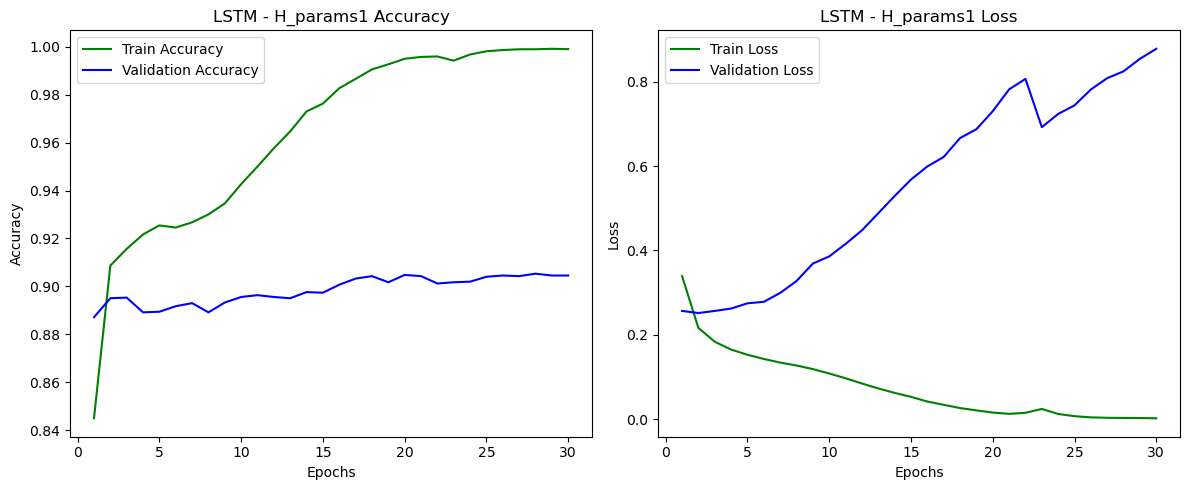

<Figure size 640x480 with 0 Axes>

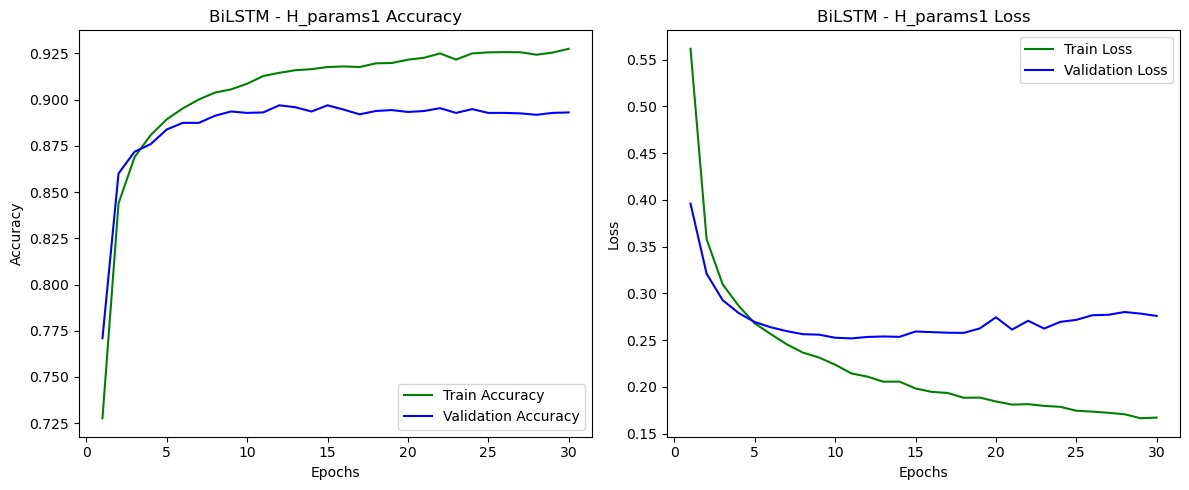

<Figure size 640x480 with 0 Axes>

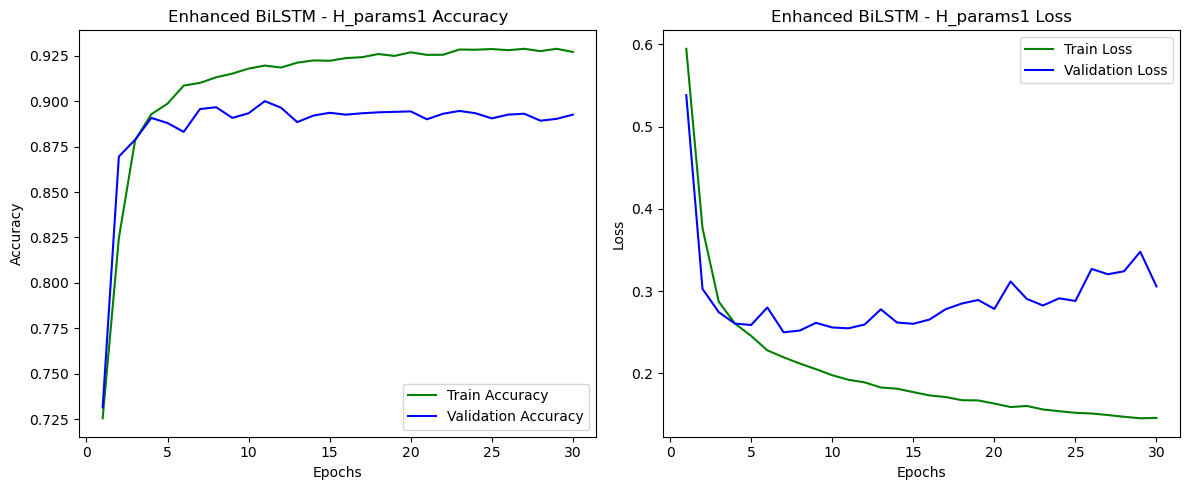

<Figure size 640x480 with 0 Axes>

In [ ]:

model_histories_set1 = {
    "LSTM": {
         "H_params1": histories_set1[list(histories_set1.keys())[0]],
         # Additional configurations can be added here:

    },
    "BiLSTM": {
         "H_params1": histories_set1[list(histories_set1.keys())[1]],
         # Additional configurations can be added here:

    },
    "Enhanced BiLSTM": {
         "H_params1": histories_set1[list(histories_set1.keys())[2]],
         # Additional configurations can be added here:

    }
}



# -----------------------------------------------------------------------------
# Plot the training curves using the nested_histories dictionary.
# -----------------------------------------------------------------------------
plot_training_curves(model_histories_set1, separate_plots=True)


# Hyper-parameter Set 2 – Training and Performance Plotting
#### This cell defines a second set of hyper-parameter dictionaries (H_params2). It then trains models with these configurations using train_multiple_models and finally plots the performance metrics using plot_model_performance.

----------------------------------------------------------------------------------------------------
The model being trained is LSTM_hparams2 and model type is lstm
The set of hyper-parameters being used are - 
{'name': 'LSTM_hparams2', 'model_type': 'lstm', 'embedding_dim': 128, 'lstm_units': 128, 'dropout_rate': 0.3, 'optimizer_lr': 0.0001, 'epochs': 30, 'batch_size': 32}

----------------------------------------------------------------------------------------------------
Epoch 1/30
489/489 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8163 - loss: 0.3945 - val_accuracy: 0.8923 - val_loss: 0.2546
Epoch 2/30
489/489 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9137 - loss: 0.2015 - val_accuracy: 0.8941 - val_loss: 0.2538
Epoch 3/30
489/489 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9244 - loss: 0.1598 - val_accuracy: 0.8910 - val_loss: 0.2796
Epoch 4/30
489/489 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.9324 - loss: 0.1353 - val_accuracy: 0.8877 - val_loss: 0.3129
E

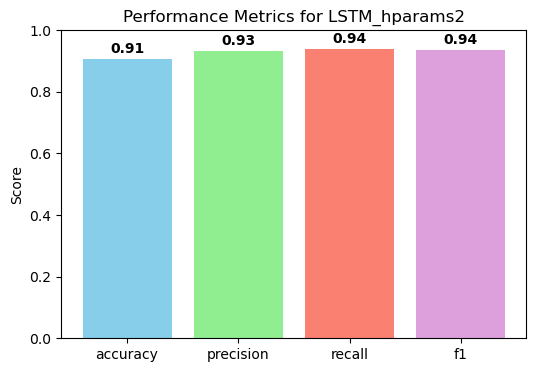

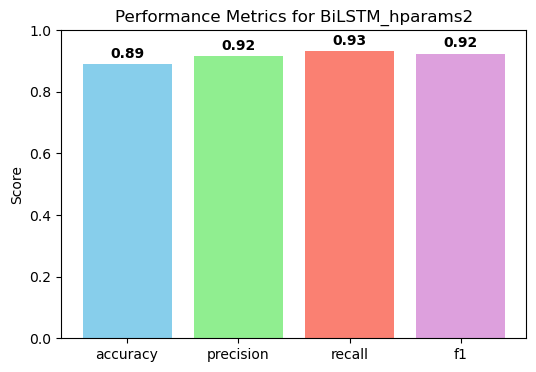

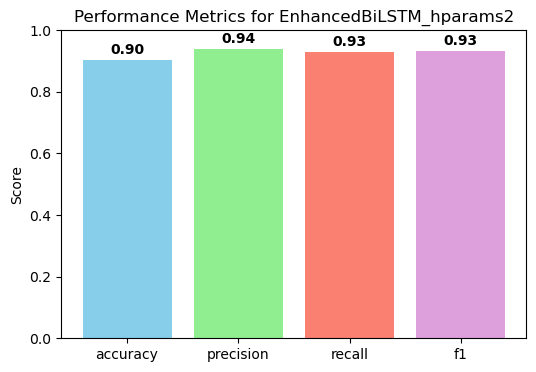

In [71]:
# -----------------------------------------------------------------------------
# Define dictionaries for a second set of model variants.
# -----------------------------------------------------------------------------
hyper_parameters_lstm2 = [
    {
        "name": "LSTM_hparams2",        # Unique identifier for the simple LSTM configuration
        "model_type": "lstm",          # Model type: simple LSTM model
        "embedding_dim": 128,          # Embedding layer dimension increased to 128
        "lstm_units": 128,             # Number of LSTM units in the LSTM layer
        "dropout_rate": 0.3,           # Dropout rate applied to embeddings/LSTM outputs
        "optimizer_lr": 1e-4,          # Optimizer learning rate set to 0.0001
        "epochs": 30,                  # Number of training epochs
        "batch_size": 32               # Batch size reduced to 32 for more granular updates
    },
    {
        "name": "BiLSTM_hparams2",      # Unique identifier for the Bidirectional LSTM configuration
        "model_type": "bilstm",        # Model type: Bidirectional LSTM
        "embedding_dim": 64,           # Embedding dimension set to 64
        "lstm_units": 128,             # Number of LSTM units for the bidirectional layer
        "dropout_rate": 0.3,           # Dropout rate for regularization
        "l2_reg": 1e-3,                # L2 regularization factor increased to 1e-3
        "optimizer_lr": 1e-3,          # Optimizer learning rate set to 0.001
        "epochs": 30,                  # Training for 30 epochs
        "batch_size": 32               # Batch size set to 32
    },
    {
        "name": "EnhancedBiLSTM_hparams2",  # Unique identifier for the Enhanced Bidirectional LSTM configuration
        "model_type": "enhanced_bilstm",     # Model type: Enhanced BiLSTM
        "embedding_dim": 64,                # Embedding dimension set to 64
        "lstm_units": 128,                  # Number of LSTM units in each branch of the BiLSTM
        "dropout_rate": 0.5,                # Dropout rate increased to 0.5 for spatial dropout layers
        "dense_dropout_rate": 0.3,          # Dropout rate for dense layers set to 0.3
        "l2_reg": 1e-3,                     # L2 regularization factor set to 1e-3
        "optimizer_lr": 1e-3,               # Optimizer learning rate set to 0.001
        "epochs": 30,                       # Number of training epochs is 30
        "batch_size": 32                    # Batch size set to 32
    }
]

# -----------------------------------------------------------------------------
# Train models using the second set of hyperparameters.
# -----------------------------------------------------------------------------
models_set2, histories_set2, metrics_dict_set2 = train_multiple_models(hyper_parameters_lstm2)

# -----------------------------------------------------------------------------
# Plot the performance metrics for each model in the second set.
# -----------------------------------------------------------------------------
plot_model_performance(metrics_dict_set2)


#  Histories for Hyper-parameters-set2 – Plotting Training Curves
#### This cell constructs a nested dictionary for training histories (for hyper-paramaters "H_params2") from the second configuration set, then calls plot_training_curves to visualize both individual and combined training curves.

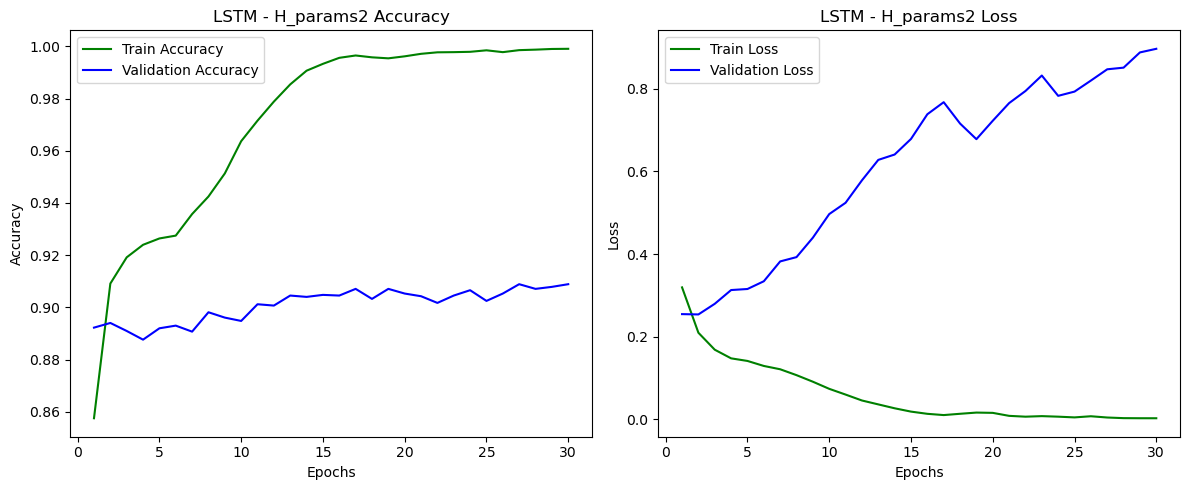

<Figure size 640x480 with 0 Axes>

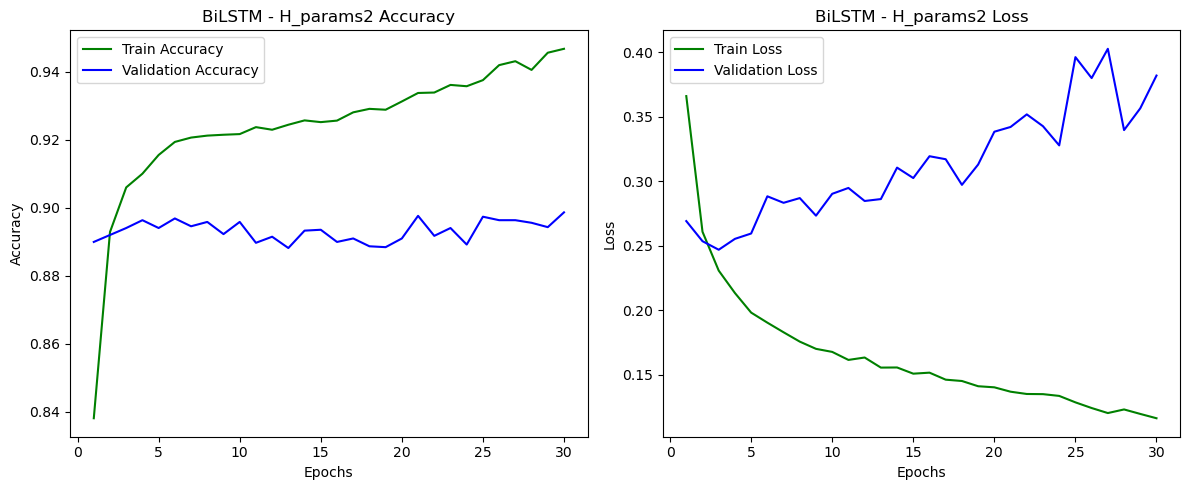

<Figure size 640x480 with 0 Axes>

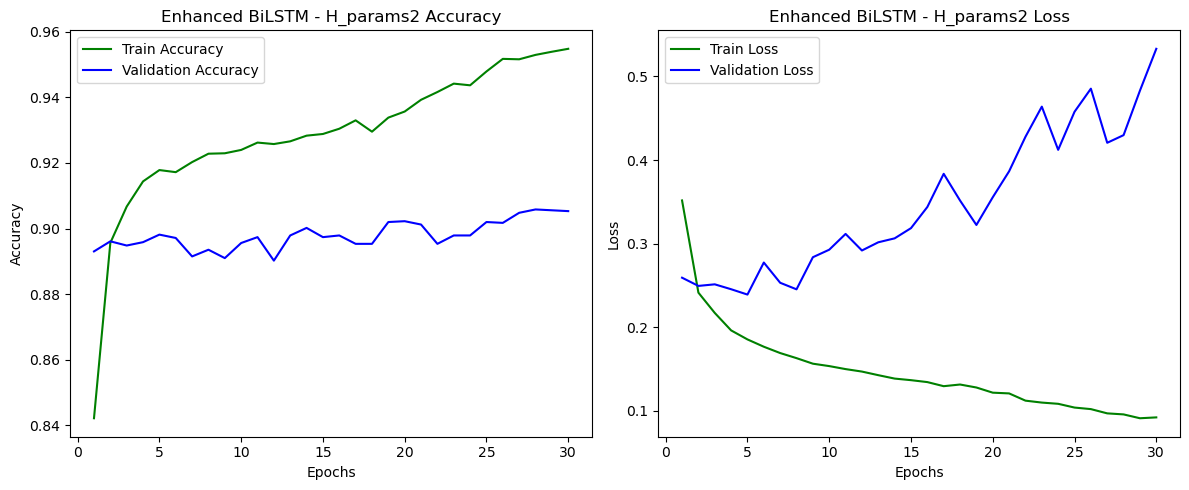

<Figure size 640x480 with 0 Axes>

In [79]:
# -----------------------------------------------------------------------------
# Construct a nested dictionary for the second set's training histori
# -----------------------------------------------------------------------------
model_histories_set2 = {
    "LSTM": {
         "H_params2": histories_set2[list(histories_set2.keys())[0]],

    },
    "BiLSTM": {
         "H_params2": histories_set2[list(histories_set2.keys())[1]],

    },
    "Enhanced BiLSTM": {
         "H_params2": histories_set2[list(histories_set2.keys())[2]],
  
    }
}

# -----------------------------------------------------------------------------
# Plot the training curves for the second set.
# -----------------------------------------------------------------------------
plot_training_curves(model_histories_set2, separate_plots=True)


# Hyperparamaters Set 3 – Training and Performance Plotting
#### This cell defines a third set of hyperparameters dictionaries (hyperparameters_set3), trains the models with these configurations, and then plots their performance metrics.

----------------------------------------------------------------------------------------------------
The model being trained is LSTM_hparams3 and model type is lstm
The set of hyper-parameters being used are - 
{'name': 'LSTM_hparams3', 'model_type': 'lstm', 'embedding_dim': 50, 'lstm_units': 64, 'dropout_rate': 0.5, 'optimizer_lr': 0.001, 'epochs': 30, 'batch_size': 64}

----------------------------------------------------------------------------------------------------
Epoch 1/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7840 - loss: 0.4525 - val_accuracy: 0.8910 - val_loss: 0.2625
Epoch 2/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9111 - loss: 0.2198 - val_accuracy: 0.8897 - val_loss: 0.2588
Epoch 3/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9215 - loss: 0.1794 - val_accuracy: 0.8912 - val_loss: 0.2548
Epoch 4/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9254 - loss: 0.1637 - val_accuracy: 0.8897 - val_loss: 0.2572
Epoch 5/30
2

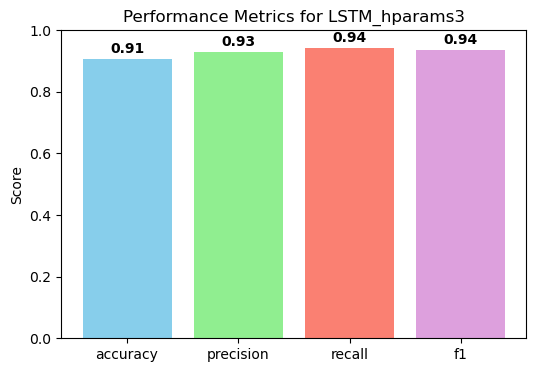

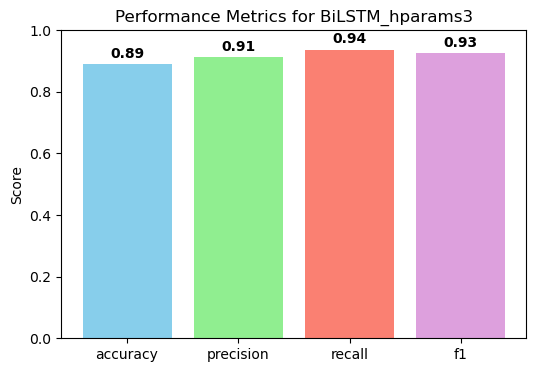

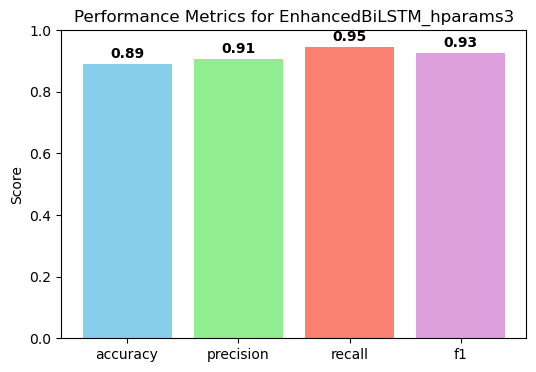

In [80]:
# -----------------------------------------------------------------------------
# Define configuration dictionaries for the third set.
# -----------------------------------------------------------------------------
hyper_parameters_lstm3 = [
    {
        "name": "LSTM_hparams3",         # Unique identifier for this LSTM configuration
        "model_type": "lstm",           # Specifies a simple LSTM model architecture
        "embedding_dim": 50,           # Embedding dimension set to 128 for a richer representation
        "lstm_units": 64,               # Reduced LSTM units (64) for computational efficiency
        "dropout_rate": 0.5,            # Increased dropout rate to 0.5 to help reduce overfitting
        "optimizer_lr": 1e-3,           # Optimizer learning rate set to 0.001 for faster convergence
        "epochs": 30,                   # Training the model for 30 epochs
        "batch_size": 64                # Batch size set to 64
    },
    {
        "name": "BiLSTM_hparams3",       # Unique identifier for this Bidirectional LSTM configuration
        "model_type": "bilstm",         # Specifies a Bidirectional LSTM model architecture
        "embedding_dim": 50,           # Embedding dimension remains at 128
        "lstm_units": 50,               # LSTM unit count set to 64
        "dropout_rate": 0.5,            # Dropout rate set to 0.5 for strong regularization
        "l2_reg": 1e-3,                 # L2 regularization factor set to 0.001 for weight decay
        "optimizer_lr": 1e-3,           # Learning rate set to 0.001
        "epochs": 30,                   # Training for 30 epochs
        "batch_size": 64                # Batch size remains 64
    },
    {
        "name": "EnhancedBiLSTM_hparams3",  # Unique identifier for this Enhanced Bidirectional LSTM configuration
        "model_type": "enhanced_bilstm",     # Specifies an enhanced Bidirectional LSTM model architecture
        "embedding_dim": 64,              # Embedding dimension set to 128 for consistency
        "lstm_units": 64,                 # Increased LSTM units to 128 for capturing complex patterns
        "dropout_rate": 0.3,               # Dropout rate reduced to 0.3 for the spatial dropout layers
        "dense_dropout_rate": 0.5,         # Dropout rate for dense layers set to 0.5 to prevent overfitting
        "l2_reg": 1e-4,                    # L2 regularization factor set to 0.0001 for a lighter regularization
        "optimizer_lr": 1e-4,              # Learning rate reduced to 0.0001 for finer weight updates
        "epochs": 30,                      # Training for 30 epochs
        "batch_size": 64                   # Batch size remains 64
    }
]

# -----------------------------------------------------------------------------
# Train models using the third set.

# -----------------------------------------------------------------------------
models_set3, histories_set3, metrics_dict_set3 = train_multiple_models(hyper_parameters_lstm3)

# -----------------------------------------------------------------------------
# Plot the performance metrics for each model in the third  set.
# -----------------------------------------------------------------------------
plot_model_performance(metrics_dict_set3)


# Histories for Hyper-parameters-set3 – Plotting Training Curves
#### This cell constructs a nested dictionary for training histories (for hyper-parameters "H_params3") from the third configuration set, then calls plot_training_curves to visualize the training curves individually and combined.

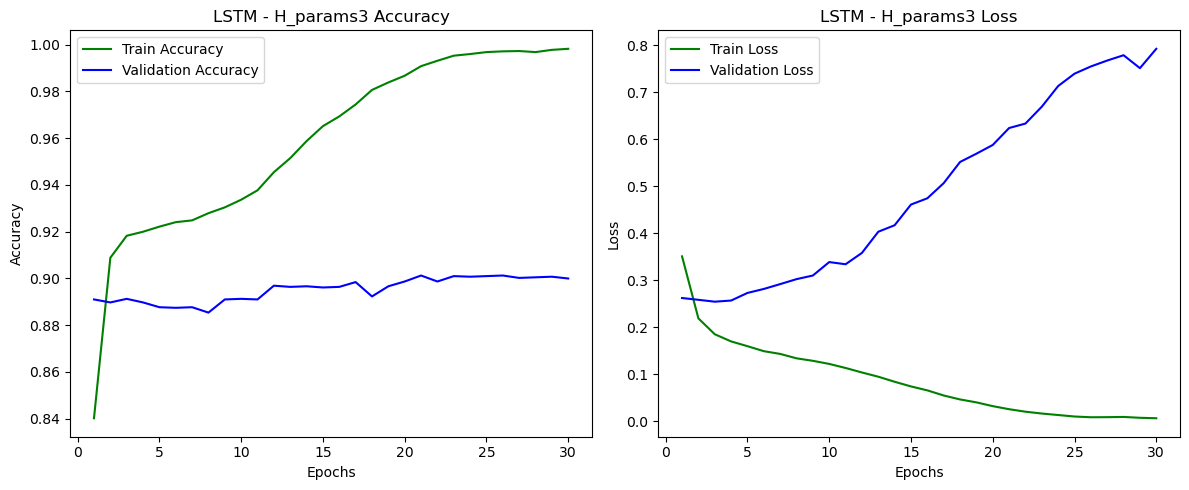

<Figure size 640x480 with 0 Axes>

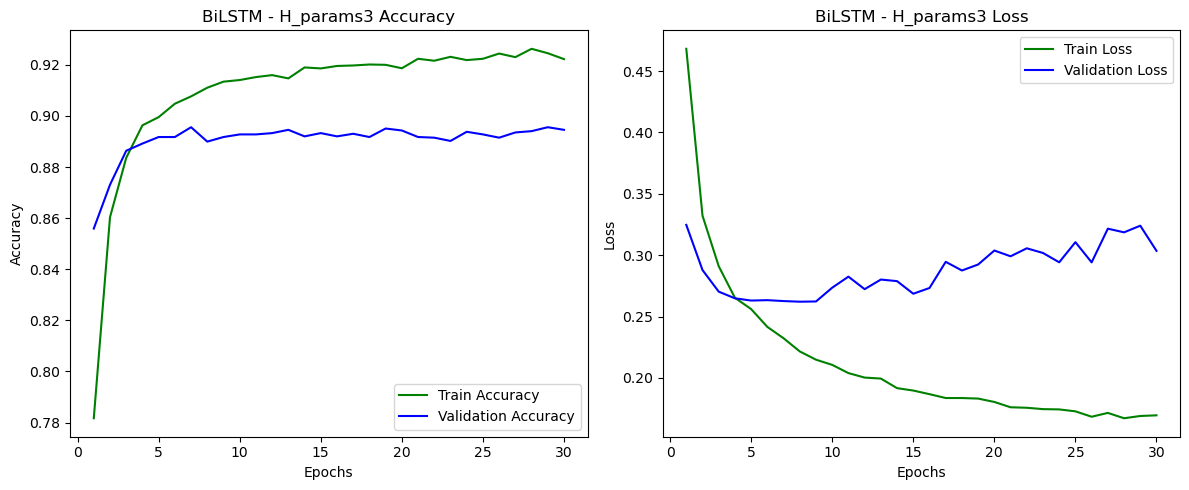

<Figure size 640x480 with 0 Axes>

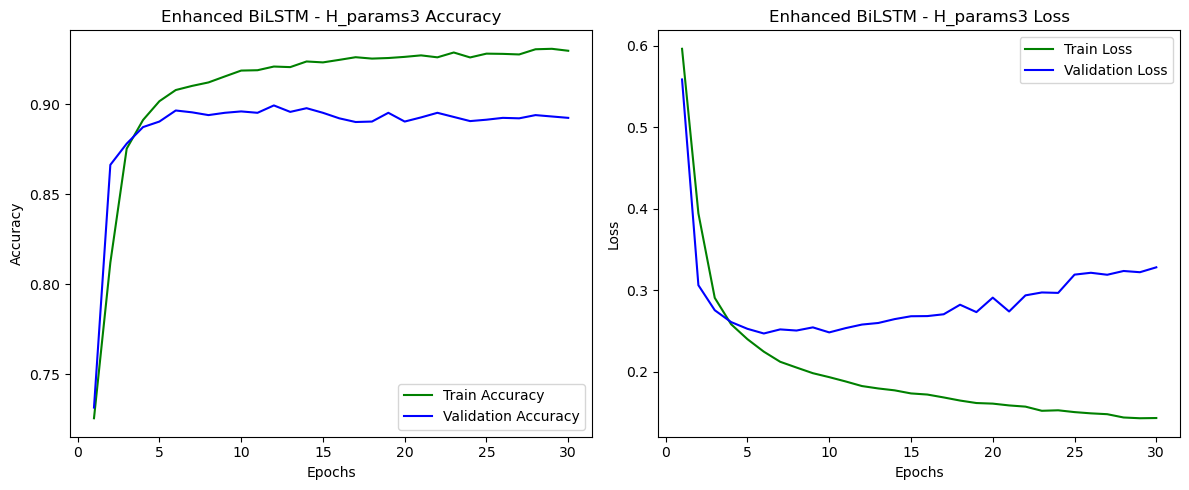

<Figure size 640x480 with 0 Axes>

In [81]:
# -----------------------------------------------------------------------------
# Construct a nested dictionary for the third set's training histories.
# -----------------------------------------------------------------------------
model_histories_set3 = {
    "LSTM": {
         "H_params3": histories_set3[list(histories_set3.keys())[0]],
    },
    "BiLSTM": {
         "H_params3": histories_set3[list(histories_set3.keys())[1]],
    },
    "Enhanced BiLSTM": {
         "H_params3": histories_set3[list(histories_set3.keys())[2]],
    }
}

# -----------------------------------------------------------------------------
# Plot the training curves for the third set.
# -----------------------------------------------------------------------------
plot_training_curves(model_histories_set3, separate_plots=True)


# Precision, Recall, ROC curve plots with confusion matrix
##### Hlper function

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns

def evaluate_model(y_true, y_pred_prob, model_set,model_name="Model"):

    # Precision-Recall Curve
    y_pred_prob = model_set[model_name].predict([padded_sentences_X_test, padded_aspects_X_test])

    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_prob)
    area_under_pr_curve = auc(recall, precision)

    # ROC-AUC Curve
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_prob)
    area_under_roc_curve = auc(fpr, tpr)

    # F1 Score
    y_pred = np.round(y_pred_prob)
    f1 = f1_score(y_true, y_pred)

    # Set up figure and axes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Plot Precision-Recall Curve
    axes[0].plot(recall, precision, label=f'Precision-Recall Curve (AUC = {area_under_pr_curve:.2f})', color='red')
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')
    axes[0].set_title(f'{model_name} Precision-Recall Curve')
    axes[0].legend()

    # Plot ROC-AUC Curve
    axes[1].plot(fpr, tpr, label=f'ROC-AUC Curve (AUC = {area_under_roc_curve:.2f})', color='darkslategray')
    axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'{model_name} ROC-AUC Curve')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Print F1 Score
    print(f'{model_name} F1 Score: {f1:.2f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # Classification Report
    print(f'{model_name} Classification Report:\n{classification_report(y_true, y_pred)}')


#### Precision, Recall, ROC curve and confusion matrix plots for Model set 1 - model 1 - LSTM

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


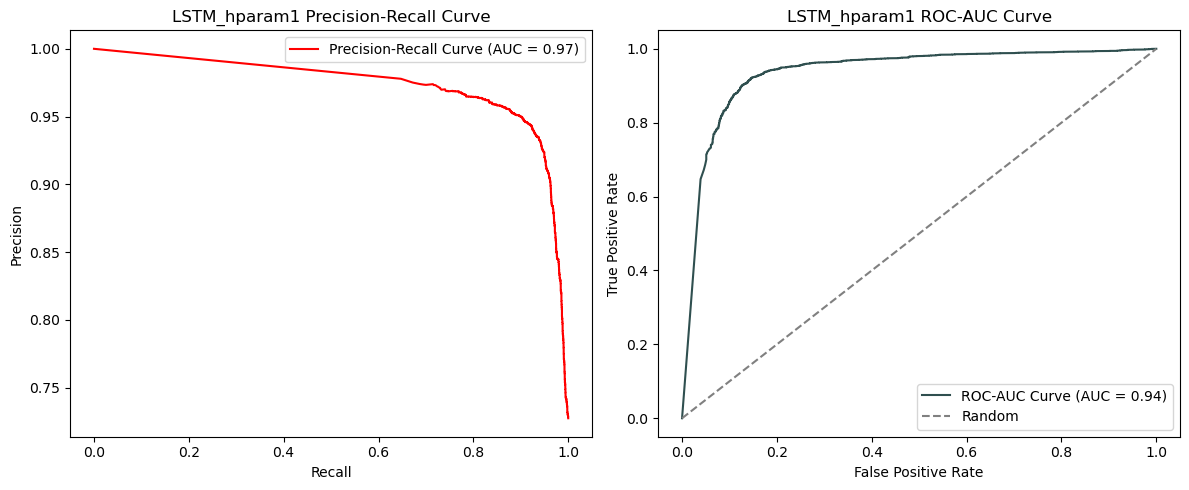

LSTM_hparam1 F1 Score: 0.94


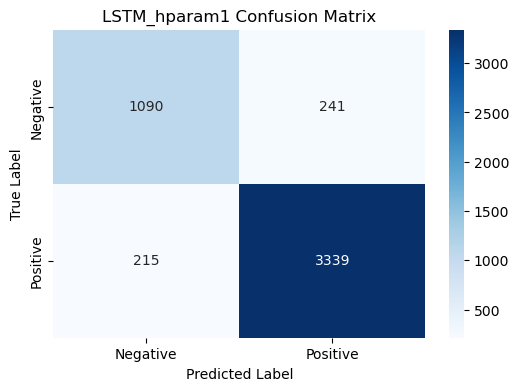

LSTM_hparam1 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1331
           1       0.93      0.94      0.94      3554

    accuracy                           0.91      4885
   macro avg       0.88      0.88      0.88      4885
weighted avg       0.91      0.91      0.91      4885



In [101]:
evaluate_model(y_test, y_pred_prob, model_name=list(models_set1.keys())[0],model_set = models_set1)

#### Precision, Recall, ROC curve and confusion matrix plots for Model set 1 - model 2 - BiLSTM

153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


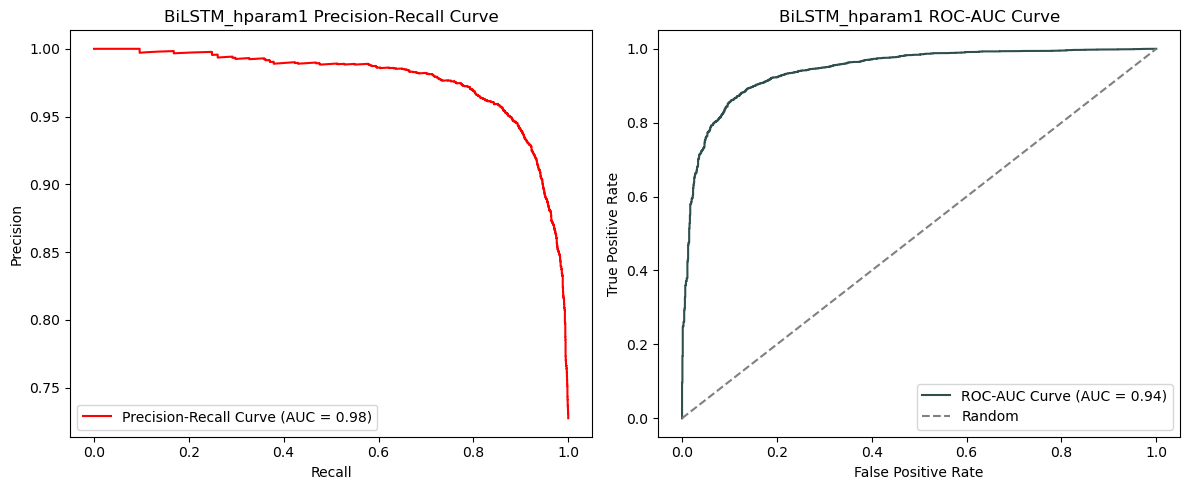

BiLSTM_hparam1 F1 Score: 0.92


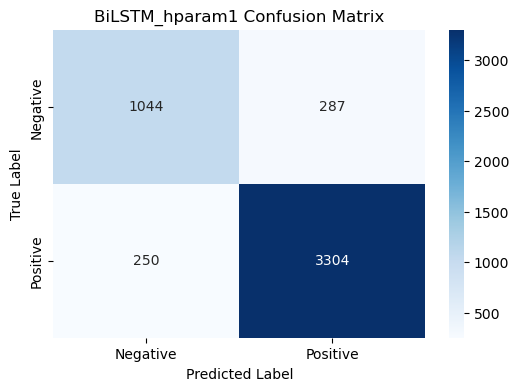

BiLSTM_hparam1 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1331
           1       0.92      0.93      0.92      3554

    accuracy                           0.89      4885
   macro avg       0.86      0.86      0.86      4885
weighted avg       0.89      0.89      0.89      4885



In [102]:
evaluate_model(y_test, y_pred_prob, model_name=list(models_set1.keys())[1],model_set = models_set1)

#### Precision, Recall, ROC curve and confusion matrix plots for Model set 1 - model 3 - Enhanced BiLSTM

153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


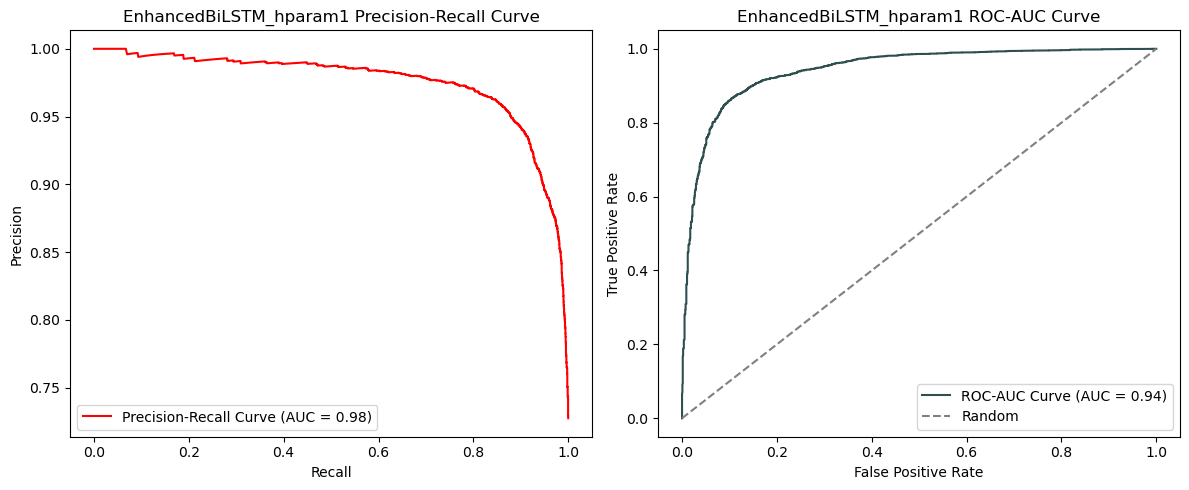

EnhancedBiLSTM_hparam1 F1 Score: 0.92


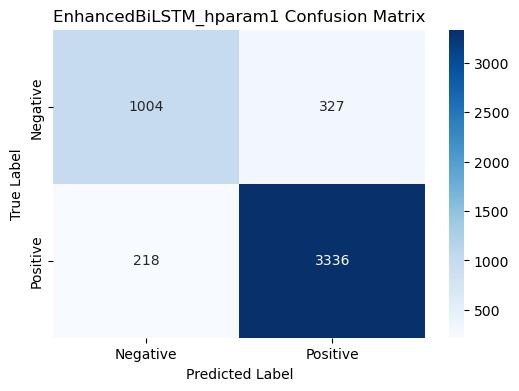

EnhancedBiLSTM_hparam1 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.79      1331
           1       0.91      0.94      0.92      3554

    accuracy                           0.89      4885
   macro avg       0.87      0.85      0.86      4885
weighted avg       0.89      0.89      0.89      4885



In [103]:
evaluate_model(y_test, y_pred_prob, model_name=list(models_set1.keys())[2],model_set = models_set1)

#### Precision, Recall, ROC curve and confusion matrix plots for Model set 2 - model 1 - LSTM

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


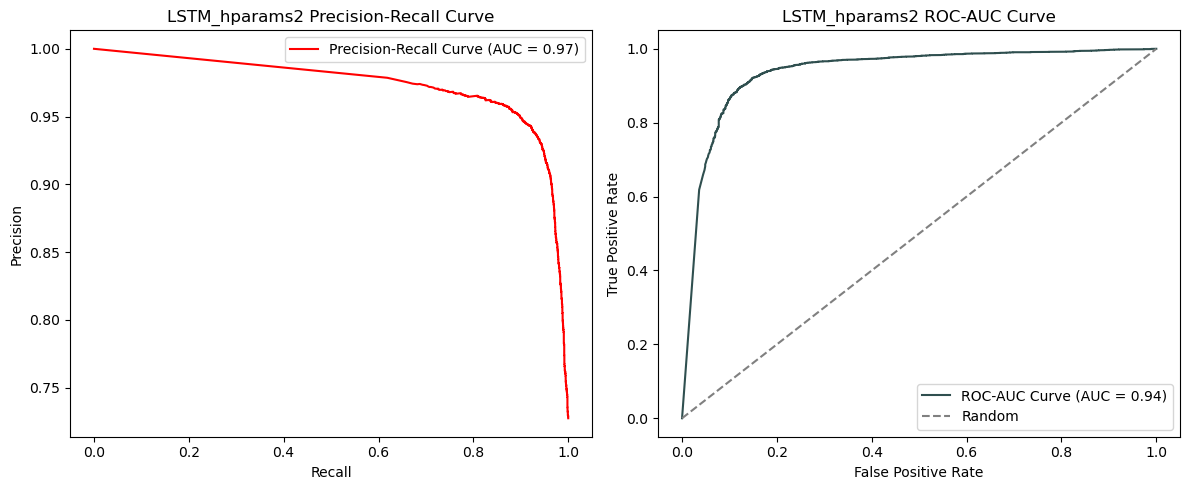

LSTM_hparams2 F1 Score: 0.94


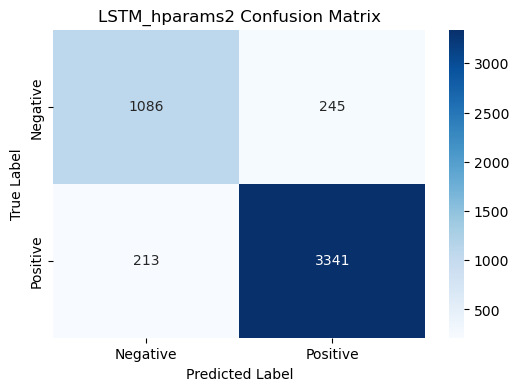

LSTM_hparams2 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1331
           1       0.93      0.94      0.94      3554

    accuracy                           0.91      4885
   macro avg       0.88      0.88      0.88      4885
weighted avg       0.91      0.91      0.91      4885



In [105]:
evaluate_model(y_test, y_pred_prob, model_name=list(models_set2.keys())[0],model_set = models_set2)

#### Precision, Recall, ROC curve and confusion matrix plots for Model set  - model 2 - BiLSTM

153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


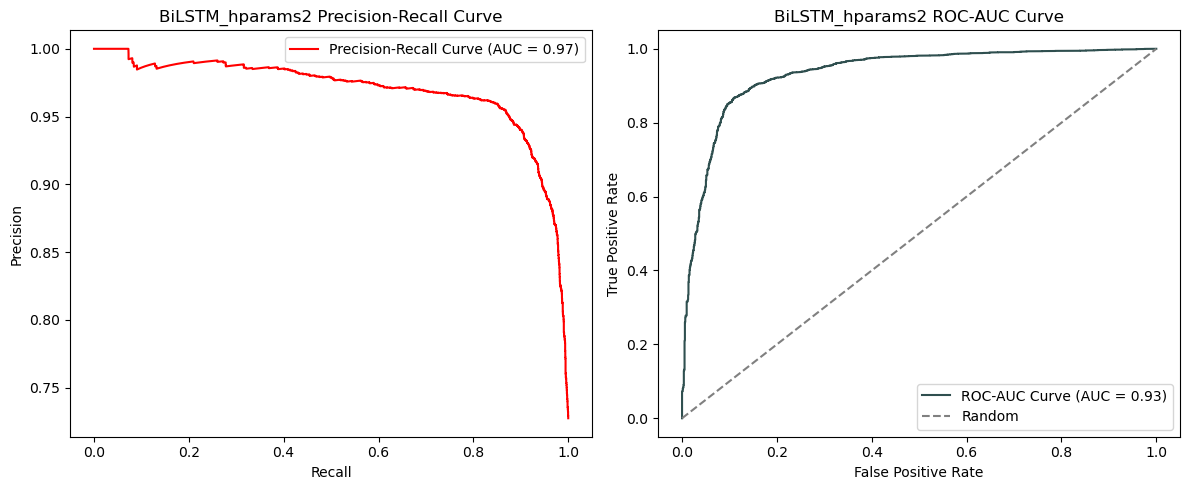

BiLSTM_hparams2 F1 Score: 0.92


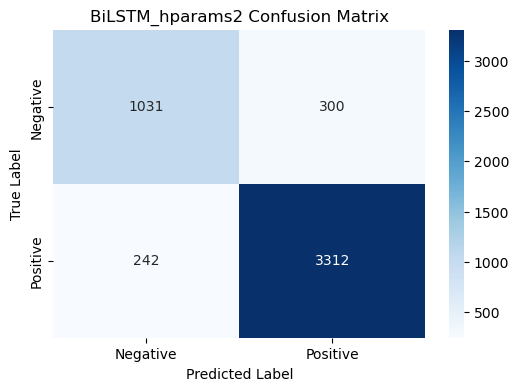

BiLSTM_hparams2 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1331
           1       0.92      0.93      0.92      3554

    accuracy                           0.89      4885
   macro avg       0.86      0.85      0.86      4885
weighted avg       0.89      0.89      0.89      4885



In [106]:
evaluate_model(y_test, y_pred_prob, model_name=list(models_set2.keys())[1],model_set = models_set2)

#### Precision, Recall, ROC curve and confusion matrix plots for Model set 2 - model 3 - Enhanced BiLSTM

153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


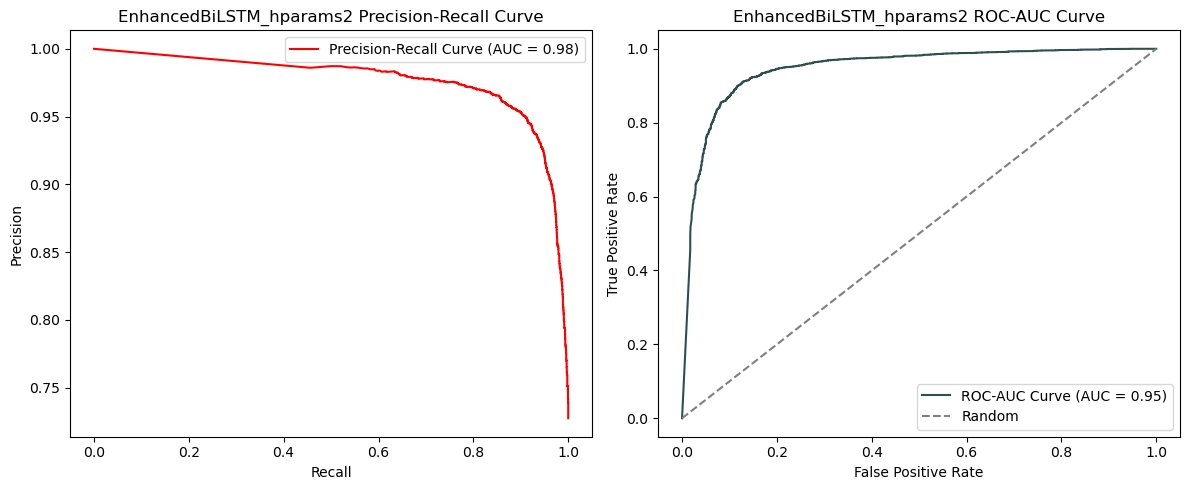

EnhancedBiLSTM_hparams2 F1 Score: 0.93


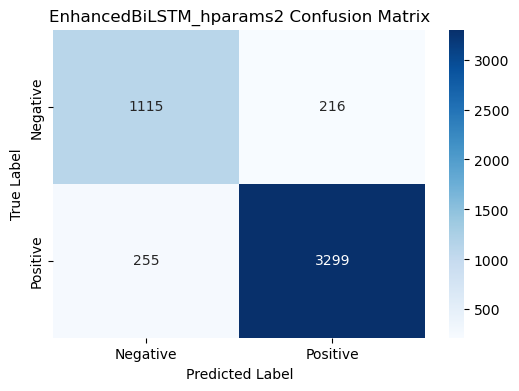

EnhancedBiLSTM_hparams2 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1331
           1       0.94      0.93      0.93      3554

    accuracy                           0.90      4885
   macro avg       0.88      0.88      0.88      4885
weighted avg       0.90      0.90      0.90      4885



In [107]:
evaluate_model(y_test, y_pred_prob, model_name=list(models_set2.keys())[2],model_set = models_set2)

#### Precision, Recall, ROC curve and confusion matrix plots for Model set 3 - model 1 - LSTM

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


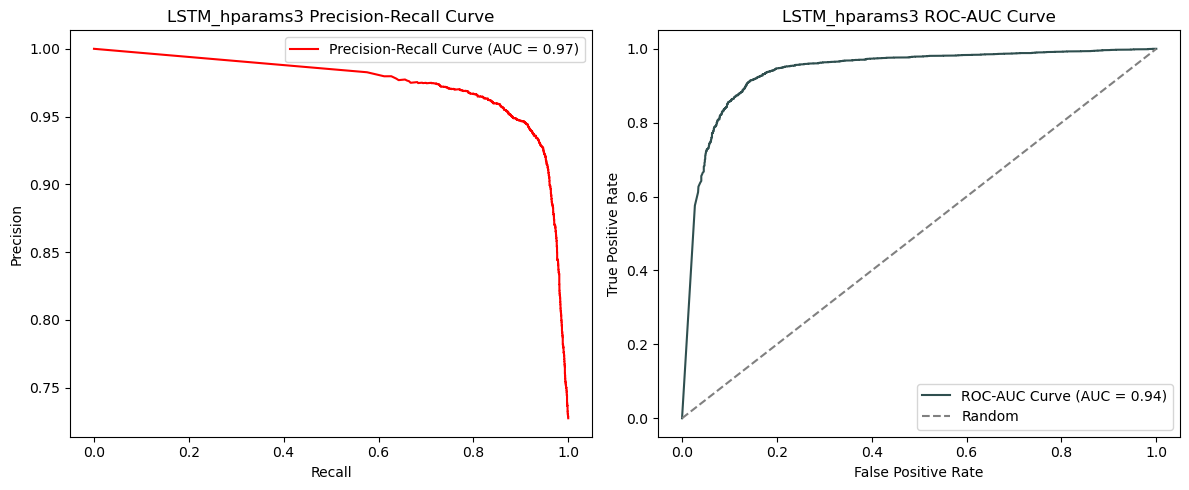

LSTM_hparams3 F1 Score: 0.94


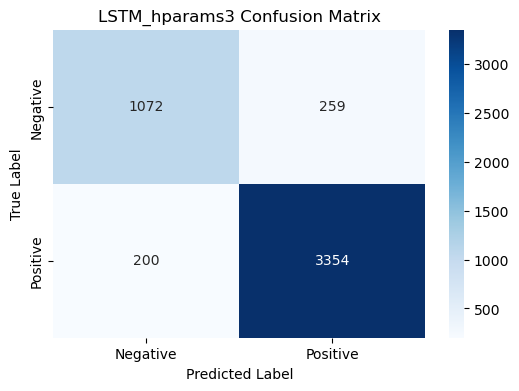

LSTM_hparams3 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1331
           1       0.93      0.94      0.94      3554

    accuracy                           0.91      4885
   macro avg       0.89      0.87      0.88      4885
weighted avg       0.91      0.91      0.91      4885



In [108]:
evaluate_model(y_test, y_pred_prob, model_name=list(models_set3.keys())[0],model_set = models_set3)

#### Precision, Recall, ROC curve and confusion matrix plots for Model set 3 - model 2 - BiLSTM

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


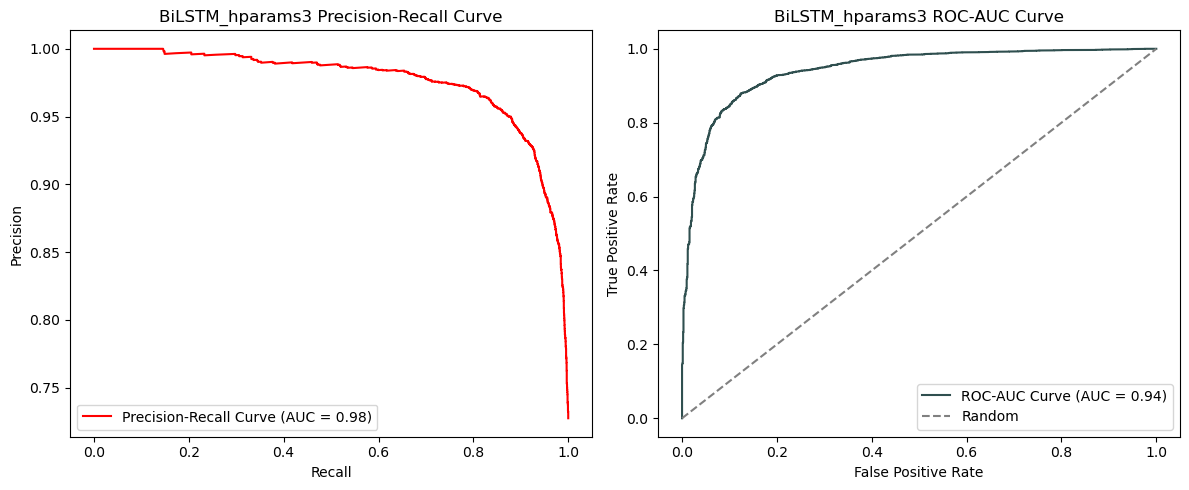

BiLSTM_hparams3 F1 Score: 0.93


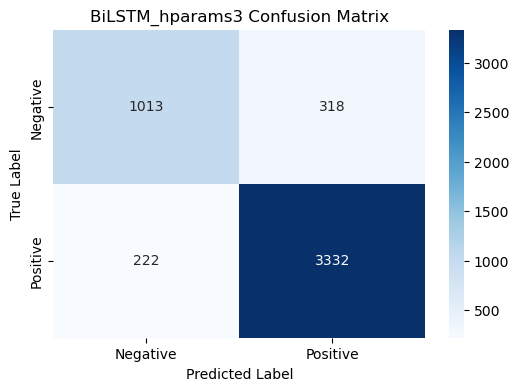

BiLSTM_hparams3 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1331
           1       0.91      0.94      0.93      3554

    accuracy                           0.89      4885
   macro avg       0.87      0.85      0.86      4885
weighted avg       0.89      0.89      0.89      4885



In [109]:
evaluate_model(y_test, y_pred_prob, model_name=list(models_set3.keys())[1],model_set = models_set3)

#### Precision, Recall, ROC curve and confusion matrix plots for Model set 3 - model 3 - Enhanced BiLSTM

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


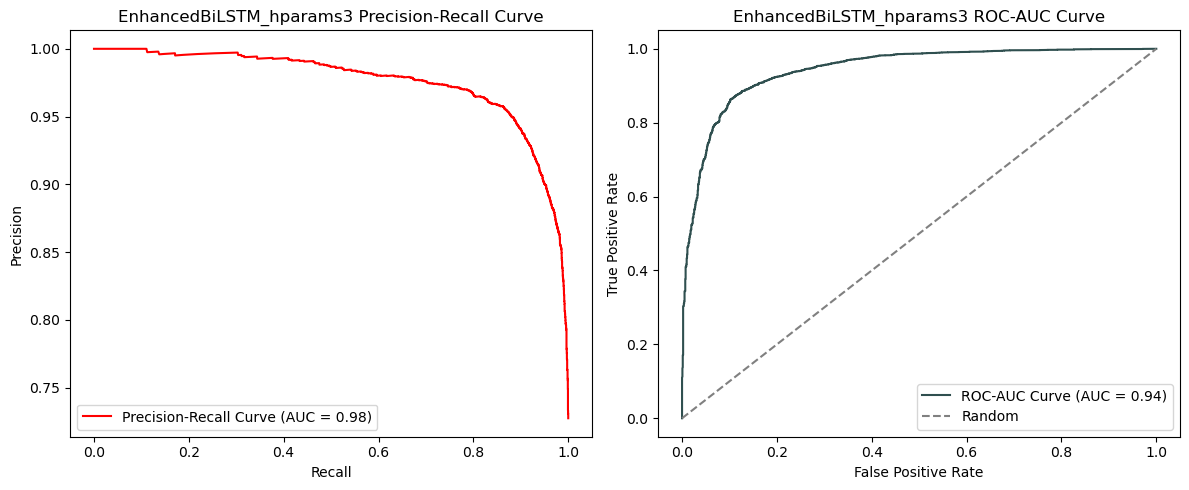

EnhancedBiLSTM_hparams3 F1 Score: 0.93


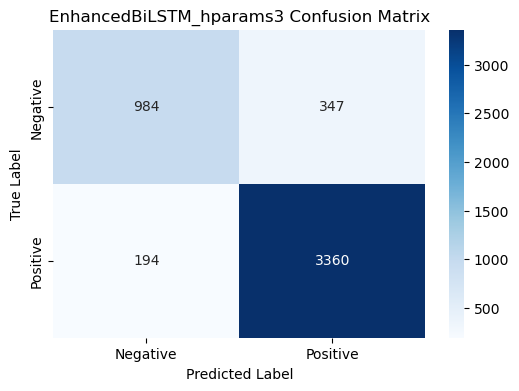

EnhancedBiLSTM_hparams3 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.78      1331
           1       0.91      0.95      0.93      3554

    accuracy                           0.89      4885
   macro avg       0.87      0.84      0.85      4885
weighted avg       0.89      0.89      0.89      4885



In [110]:
evaluate_model(y_test, y_pred_prob, model_name=list(models_set3.keys())[2],model_set = models_set3)

In [ ]:
import matplotlib.pyplot as plt

def plot_metric_comparison_multi(model_histories_list, metric_name='val_accuracy'):

    results = {}
    
    # Iterate over each history dictionary in the list
    for model_histories in model_histories_list:
        # Iterate through each model type (e.g., "LSTM")
        for model_type, config_dict in model_histories.items():
            # Loop through each configuration (subkey, e.g., "H_params3")
            for config_name, history in config_dict.items():
                # Construct a composite key combining model type and configuration subkey
                composite_key = f"{model_type} ({config_name})"
                # Check if the desired metric exists in the history
                if metric_name in history.history:
                    # For metrics like accuracy, f1, or precision, take the maximum value across epochs
                    best_value = max(history.history[metric_name])
                    results[composite_key] = best_value
                else:
                    print(f"Metric '{metric_name}' not found for {model_type} - {config_name}. Skipping.")
    
    # Sort the results by metric value in descending order
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    if sorted_results:
        labels, scores = zip(*sorted_results)
    else:
        labels, scores = [], []
    
    # Create a horizontal bar plot
    plt.figure(figsize=(8, 4))
    plt.barh(labels, scores, color='skyblue')
    plt.xlabel(metric_name)
    plt.title(f'Model Comparison based on {metric_name}')
    plt.gca().invert_yaxis()  # Invert y-axis so the best configuration is at the top
    plt.show()



## Comparison of models based upon the metric 


#### Based upon val accuracy 

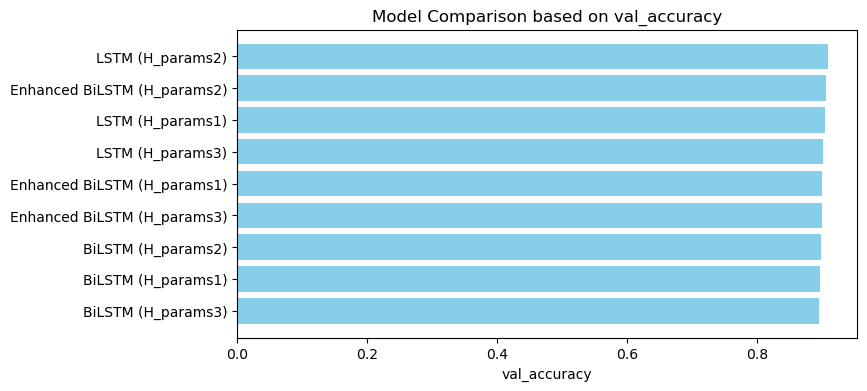

In [133]:
plot_metric_comparison_multi([model_histories_set3,model_histories_set2,model_histories_set1], metric_name='val_accuracy')

#### Based upon train accuracy 

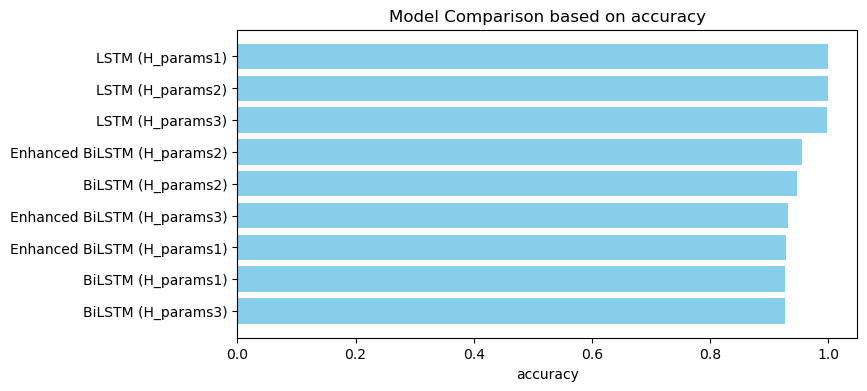

In [146]:
plot_metric_comparison_multi([model_histories_set3,model_histories_set2,model_histories_set1], metric_name='accuracy')

#### Based upon train loss

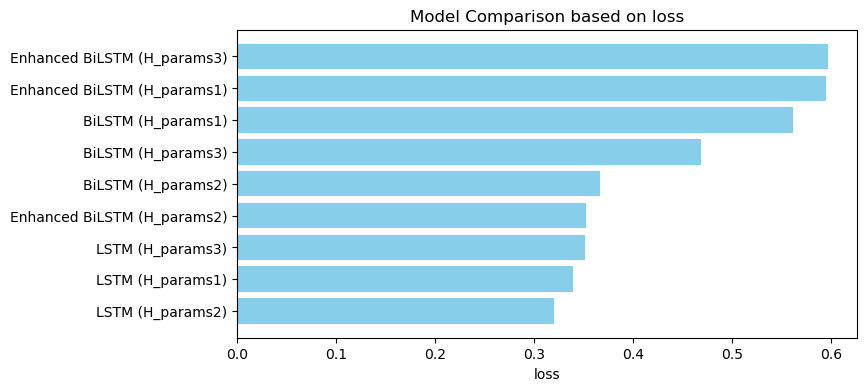

In [147]:
plot_metric_comparison_multi([model_histories_set3,model_histories_set2,model_histories_set1], metric_name='loss')